# Notebook for training AutoBound's deep learning model

In [1]:
from fastai.imports import *
from fastai.vision import *
import torch.nn as nn
import torch.optim as optim
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_loc = Path('autoboundData')

In [3]:
label_dir = data_loc/'segmentedImages'
image_dir = data_loc/'originalImages'

codes = np.loadtxt(data_loc/'codes.txt', dtype=str)
get_y_fn = lambda x: label_dir/f'{x.stem}_segmented{x.suffix}'

In [4]:
data = (SegmentationItemList.from_folder(image_dir)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), tfm_y=True, size=256)
        .databunch(bs=9, path=data_loc, num_workers = 0)
        .normalize(imagenet_stats))

In [5]:
data

ImageDataBunch;

Train: LabelList (100 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: autoboundData/originalImages;

Valid: LabelList (25 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: autoboundData/originalImages;

Test: None

In [6]:
class SegmentationCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(SegmentationCrossEntropyLoss, self).__init__()
        
    def forward(self, preds, targets):
        loss = nn.functional.binary_cross_entropy_with_logits(preds, targets.float())
        return loss

In [7]:
class BuildingSegmenterNet(nn.Module):
    def __init__(self):
        super(BuildingSegmenterNet, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(3, 16, (5,5)),
            nn.MaxPool2d((2,2))
        )
        self.seq2 = nn.Sequential(
            nn.Linear((126*126*16), 512),
            nn.ReLU()
        )
        self.dropout1 = nn.Dropout(0.33)
        self.seq3 = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU()
        )
        self.seq4 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.seq5 = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU()
        )
        self.seq6 = nn.Sequential(
            nn.Linear(512, 256*256),
            nn.ReLU()
        )
        self.seq7 = nn.Sequential(
            nn.Conv2d(1, 1, (3,3), padding = 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.seq1(x)
        x = x.view(-1, 126*126*16)
        x = self.seq2(x)
        x = self.seq3(x)
        x = self.dropout1(x)
        x = self.seq4(x)
        x = self.seq5(x)
        x = self.seq6(x)
        x = x.view(-1, 1, 256, 256)
        x = self.seq7(x)
        return x

In [8]:
learn = Learner(data = data, model=BuildingSegmenterNet(), loss_func = SegmentationCrossEntropyLoss())

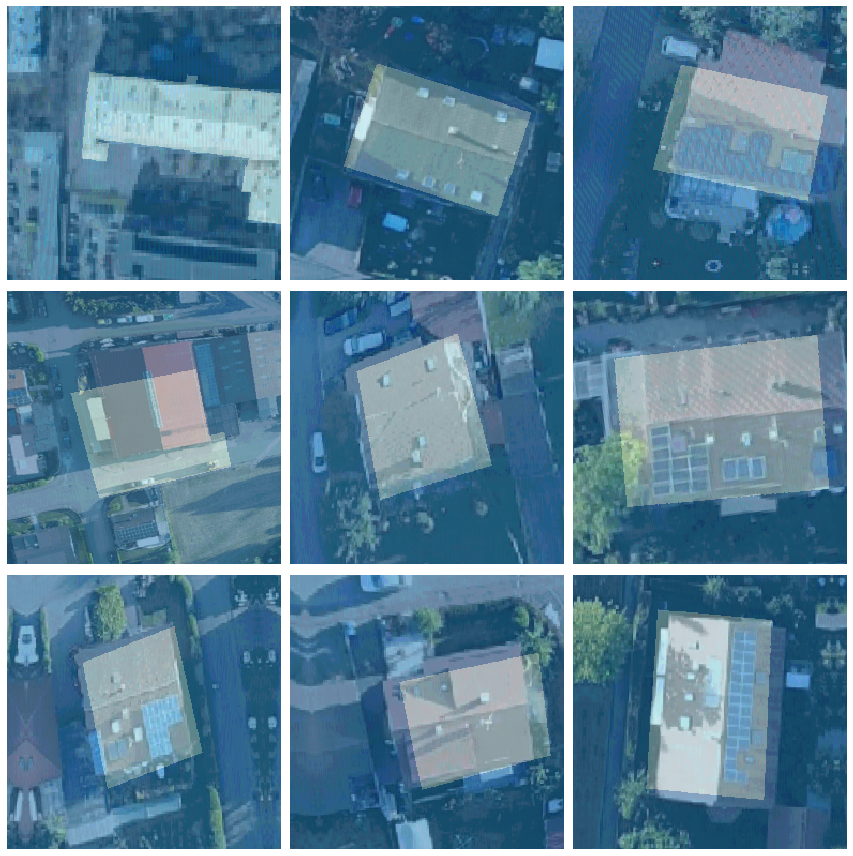

In [9]:
data.show_batch()

In [10]:
learn.fit_one_cycle(30, 2e-3)

epoch,train_loss,valid_loss,time
0,-24.891312,-22.687265,00:40
1,-24.603289,-22.750254,00:36
2,-24.499453,-22.819569,00:37
3,-24.568327,-22.917818,00:37
4,-24.443737,-23.065336,00:37
5,-24.674124,-23.267084,00:36
6,-24.644297,-23.512104,00:36
7,-24.818005,-23.792213,00:36
8,-25.078613,-24.123081,00:37
9,-25.341747,-24.433388,00:37


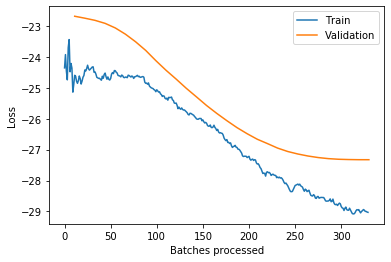

In [11]:
learn.recorder.plot_losses()

In [12]:
torch.save(learn.model, "autoboundModel.pth")

/anaconda3/envs/autoboundserver/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type BuildingSegmenterNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


(-0.5, 255.5, 255.5, -0.5)

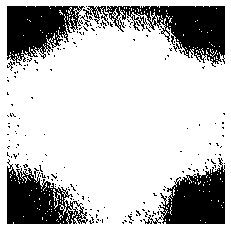

In [13]:
batch = data.one_batch(DatasetType.Valid)
res = learn.model(batch[0])
img = torch.round(res[3][0].detach()).int().numpy()
plt.imshow(img, cmap='gray')
plt.axis('off')

In [14]:
kernel2 = np.ones((9,9))*-1
kernel2[4][4] = 81

In [15]:
img = torch.round(res[3][0].detach()).int().numpy()

In [16]:
img = Image.fromarray((img*255).astype(np.uint8))
img = img.convert('RGB')

In [17]:
cv_image = np.array(img)
img = cv_image[:, :, ::-1].copy()

In [18]:
canvas = np.zeros(img.shape, np.uint8)
img2gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(img2gray,250,255,cv2.THRESH_BINARY_INV)
contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cnt = contours[0]
max_area = cv2.contourArea(cnt)

for cont in contours:
    if cv2.contourArea(cont) > max_area:
        cnt = cont
        max_area = cv2.contourArea(cont)

perimeter = cv2.arcLength(cnt,True)
epsilon = 0.01*cv2.arcLength(cnt,True)
approx = cv2.approxPolyDP(cnt,epsilon,True)

hull = cv2.convexHull(cnt)